In [6]:
import skimage
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
img_path = '/home/devcloud/spacenet5data/moscow/results_xeon4_devcloud/sn5_baseline/folds/fold0_SN5_roads_train_AOI_7_Moscow_PS-MS_chip994.tif'

mask_pred.shape: (8, 1300, 1300)


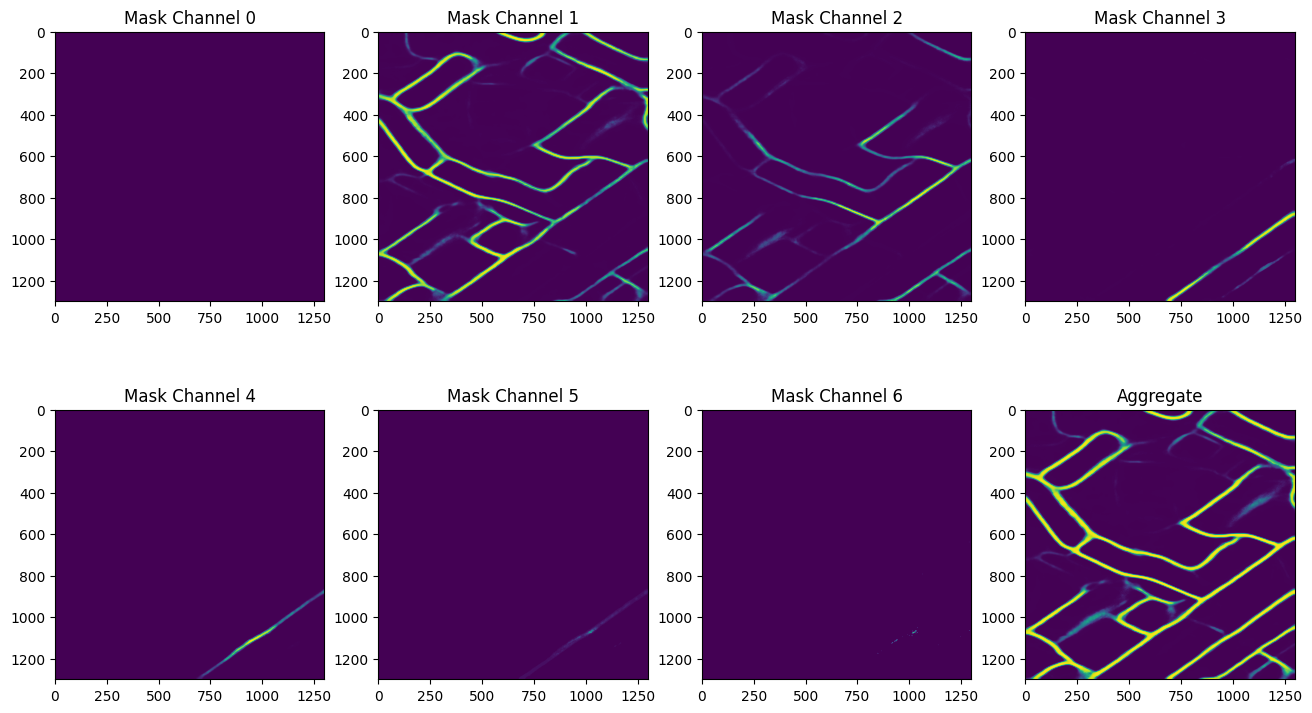

In [3]:
# inspect

mask_pred = skimage.io.imread(img_path)
print("mask_pred.shape:", mask_pred.shape)

# plot all layers
fig, axes = plt.subplots(2, 4, figsize=(16, 9))
for i, ax in enumerate(axes.flatten()):
    if i < (len(axes.flatten()) - 1):
        title = 'Mask Channel {}'.format(str(i))
    else:
        title = 'Aggregate' 
    ax.imshow(mask_pred[i,:,:])
    ax.set_title(title)

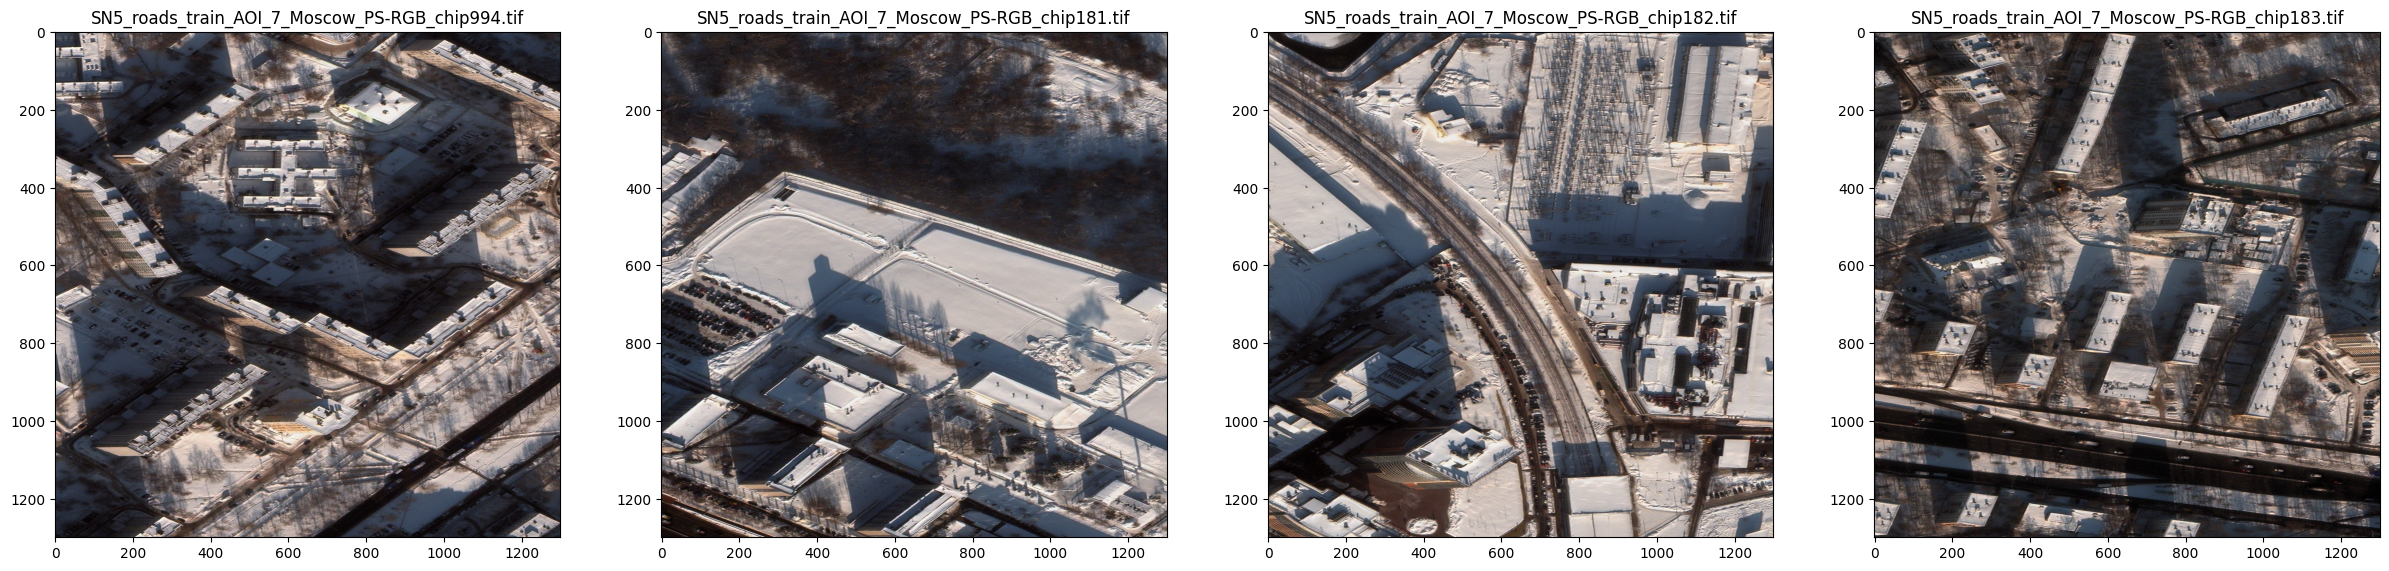

Image array shape is (1300, 1300, 3)


In [8]:
#Showing some sample images
image_dir = '/home/devcloud/spacenet5data/moscow/data/PS-RGB' #replace with your local path to the images
image_names = ['SN5_roads_train_AOI_7_Moscow_PS-RGB_chip994.tif',
               'SN5_roads_train_AOI_7_Moscow_PS-RGB_chip181.tif',
               'SN5_roads_train_AOI_7_Moscow_PS-RGB_chip182.tif',
               'SN5_roads_train_AOI_7_Moscow_PS-RGB_chip183.tif']
full_path_images = [Path(image_dir,img) for img in image_names]

fig = plt.figure(figsize=(30, 10))
columns = 4
rows = 1
ax = []
for idx,num in enumerate(range(columns*rows)):
    img = skimage.io.imread(full_path_images[idx])
    ax.append(fig.add_subplot(rows,columns,num+1))
    ax[-1].set_title(image_names[idx])
    plt.imshow(img)
plt.show()
print(f'Image array shape is {img.shape}')

In [ ]:
import torch
import os
import sys
module_path = '/home/devcloud/cresi/cresi/net' # or the path to your source code
sys.path.insert(0, module_path)

module_path = '/home/devcloud/cresi/cresi' # or the path to your source code
sys.path.insert(0, module_path)

import pytorch_zoo
from dataset.neural_dataset import SequentialDataset
from torch.utils.data.dataloader import DataLoader as PytorchDataLoader
from net.dataset.reading_image_provider import ReadingImageProvider
from net.pytorch_utils.concrete_eval import FullImageEvaluator
from net.dataset.raw_image import RawImageType
from utils.utils import update_config, get_csv_folds
from configs.config import Config
import json
import tqdm

In [ ]:
path_model_weights = '/home/devcloud/spacenet5data/moscow/results_xeon4_devcloud/weights/sn5_baseline/fold0_best.pth'

In [ ]:
model = torch.load(path_model_weights)
model.train()
print('')

In [ ]:
class RawImageTypePad(RawImageType):
    # global config
    def finalyze(self, data):
        # border reflection of 22 yields a field size of 1344 for 1300 pix inputs
        return self.reflect_border(data, 22)  #22)

path_images = '/home/devcloud/spacenet5data/moscow/data/PS-MS'
paths = {
        'masks': '',
        'images': path_images
        }
fn_mapping = {
    'masks': lambda name: os.path.splitext(name)[0] + '.tif'  #'.png'
}
image_suffix = ''
num_channels = 8
save_dir = '/home/devcloud/test_eval'
test=True
num_workers=0
save_im_gdal_format = False
nfolds = 1
config_path = '/home/devcloud/cresi/cresi/configs/ben/v5_sn5_baseline_ben.json'
weight_dir = '/home/devcloud/spacenet5data/moscow/results_xeon4_devcloud/weights/sn5_baseline'

# get config
with open(config_path, 'r') as f:
    cfg = json.load(f)
config = Config(**cfg)
config = update_config(config, target_rows=config.eval_rows, target_cols=config.eval_cols)


with torch.no_grad():
    ds = ReadingImageProvider(RawImageTypePad, paths, fn_mapping, image_suffix=image_suffix, num_channels=num_channels)

    folds = [([], list(range(len(ds)))) for i in range(nfolds)]
    if torch.cuda.is_available():
        num_workers = 0 if os.name == 'nt' else 2
    else:
        # get connection error if more than 0 workers and cpu:
        #   https://discuss.pytorch.org/t/data-loader-crashes-during-training-something-to-do-with-multiprocessing-in-docker/4379/5
        num_workers = 0

    print("num_workers:", num_workers)
    keval = FullImageEvaluator(config, ds, save_dir=save_dir, test=test,
                               flips=3, num_workers=num_workers,
                               border=22,
                               save_im_gdal_format=save_im_gdal_format)
    for fold, (t, e) in enumerate(folds):
        print("fold:", fold)
        print(f'val_indexes={(t,e)}')
        
        
    
        num_workers = 0
        batch_size = 33

        val_dataset = SequentialDataset(ds, e,
                                        stage='test', config=config,
                                        transforms=None)
        val_dl = PytorchDataLoader(val_dataset,
                                   batch_size=batch_size,
                                   num_workers=0,
                           drop_last=False)
        
        break
    
    

In [ ]:
val_dataset[0]['image'].shape

In [ ]:
pbar = tqdm.tqdm(val_dl, total=len(val_dl))

In [ ]:
for data in pbar:
    samples = torch.autograd.Variable(data['image'], volatile=True)
    predicted = model(samples)
    break